In [1]:
import pandas as pd
import sys
import os
import numpy as np
import base64
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import matplotlib.pyplot as plt

sys.path.append("/mnt/data2/datasets_lfay/MedImageInsights")
from MedImageInsight.medimageinsightmodel import MedImageInsight
sys.path.append("/mnt/data2/datasets_lfay/MedImageInsights/predictions")
from utils import read_image, zero_shot_prediction, extract_findings_and_impressions, create_wandb_run_name


/mnt/data2/datasets_lfay/MedImageInsights/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Prompt templates
prompt_templates = [
    "",
    "chest ",
    "x-ray ",
    "chest x-ray ",
    "chest x-ray anteroposterior ",
    "chest x-ray posteroanterior "
]


: 

In [3]:
# generate prompts for each class
template_disease = [p+ "Pneumonia" for p in prompt_templates]
template_no_disease = [p + "No Finding" for p in prompt_templates]

: 

### Prompt shuffeling

In [4]:
prompt_items = ["chest", "x-ray", "anteroposterior"]

# create random prompts by shuffling the prompt items. The word "Pneumonia" is always included in the prompt, positioned randomly
templates_pneumonia = ["Pneumonia"]
for i in range(1000):
    # select random amount of prompt items
    n = np.random.randint(1, 4)
    prompt = np.random.choice(prompt_items, n, replace=False)
    # add "Pneumonia" to the prompt
    prompt = np.insert(prompt, np.random.randint(0, n+1), "Pneumonia")
    prompt = " ".join(prompt)
    templates_pneumonia.append(prompt)

print(len(templates_pneumonia))
print(len(set(templates_pneumonia)))

templates_no_finding = ["No Finding"]
for i in range(1000):
    # select random amount of prompt items
    n = np.random.randint(1, 4)
    prompt = np.random.choice(prompt_items, n, replace=False)
    # add "Pneumonia" to the prompt
    prompt = np.insert(prompt, np.random.randint(0, n+1), "No Finding")
    prompt = " ".join(prompt)
    templates_no_finding.append(prompt)

print(len(templates_no_finding))


1001
49
1001


: 

In [5]:
prompts_disease = list(set(templates_pneumonia))
prompts_no_disease = list(set(templates_no_finding))

: 

In [2]:
classifier = MedImageInsight(
    model_dir="/mnt/data2/datasets_lfay/MedImageInsights/MedImageInsight/2024.09.27",
    vision_model_name="medimageinsigt-v1.0.0.pt",
    language_model_name="language_model.pth"
)
classifier.load_model()

Model loaded successfully on device: cuda


In [10]:
embeddings_disease = classifier.encode(texts=prompts_disease)["text_embeddings"]
embeddings_no_disease = classifier.encode(texts=prompts_no_disease)["text_embeddings"]

print(embeddings_disease.shape)
print(embeddings_no_disease.shape)

: 

In [14]:
# Compute average
average_embedding_disease = np.mean(embeddings_disease, axis=0)
average_embedding_no_disease = np.mean(embeddings_no_disease, axis=0)
averaged_embeddings_shuffled = np.vstack([average_embedding_no_disease, average_embedding_disease])

print(average_embedding_disease.shape)
print(average_embedding_no_disease.shape)
print(averaged_embeddings_shuffled.shape)

(1024,)
(1024,)
(2, 1024)


: 

In [15]:
# Save shuffeled average embeddings

np.save("/mnt/data2/datasets_lfay/MedImageInsights/data/text_embeddings/shuffled/averaged_embeddings_shuffled_templates.npy", averaged_embeddings_shuffled)

: 

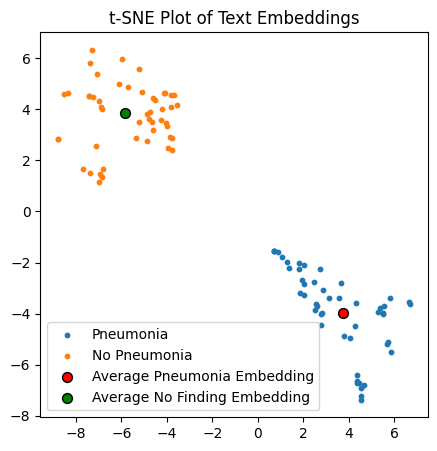

: 

In [36]:
# Create tsne scatter plot of embeddings colored by class
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

embeddings_disease = np.vstack([embeddings_disease, average_embedding_disease])
embeddings_no_disease = np.vstack([embeddings_no_disease, average_embedding_no_disease])

all_embeddings = np.vstack([embeddings_disease, embeddings_no_disease])

all_embeddings_tsne = tsne.fit_transform(all_embeddings)


embeddings_disease_tsne = all_embeddings_tsne[:len(embeddings_disease)]
embeddings_no_disease_tsne = all_embeddings_tsne[len(embeddings_disease):]

# Plot
plt.figure(figsize=(5, 5))
plt.scatter(embeddings_disease_tsne[:-1, 0], embeddings_disease_tsne[:-1, 1], label="Pneumonia", s=10, color="C0")
plt.scatter(embeddings_no_disease_tsne[:-1, 0], embeddings_no_disease_tsne[:-1, 1], label="No Pneumonia", s=10, color="C1")
plt.scatter(
    embeddings_disease_tsne[-1, 0], embeddings_disease_tsne[-1, 1], 
    label="Average Pneumonia Embedding", color="red", s=50, edgecolors="black"
)
plt.scatter(
    embeddings_no_disease_tsne[-1, 0], embeddings_no_disease_tsne[-1, 1], 
    label="Average No Finding Embedding", color="green", s=50, edgecolors="black"
)
plt.legend(loc="best")
plt.title("t-SNE Plot of Text Embeddings")
plt.show()

### Promot shuffling + fixed label (last)

In [36]:
prompt_items = ["chest", "x-ray", "anteroposterior"]

# create random prompts by shuffling the prompt items. The word "Pneumonia" is always included in the prompt, positioned randomly
templates_pneumonia = ["Pneumonia"]
for i in range(100):
    # select random amount of prompt items
    n = np.random.randint(1, 4)
    prompt = np.random.choice(prompt_items, n, replace=False).tolist()
    prompt.append("Pneumonia")
    # add "Pneumonia" to the prompt
    prompts = " ".join(prompt)

    templates_pneumonia.append(prompts)
    
print(len(templates_pneumonia))
print(len(set(templates_pneumonia)))

templates_no_finding = ["No Finding"]
for i in range(100):
    # select random amount of prompt items
    n = np.random.randint(1, 4)
    prompt = np.random.choice(prompt_items, n, replace=False).tolist()
    prompt.append("No Finding")
    # add "Pneumonia" to the prompt
    prompts = " ".join(prompt)

    templates_no_finding.append(prompts)

print(len(templates_no_finding))
print(len(set(templates_no_finding)))

prompts_disease = list(set(templates_pneumonia))
prompts_no_disease = list(set(templates_no_finding))

embeddings_disease = classifier.encode(texts=prompts_disease)["text_embeddings"]
embeddings_no_disease = classifier.encode(texts=prompts_no_disease)["text_embeddings"]

print(embeddings_disease.shape)
print(embeddings_no_disease.shape)

# Compute average
average_embedding_disease = np.mean(embeddings_disease, axis=0)
average_embedding_no_disease = np.mean(embeddings_no_disease, axis=0)

averaged_embeddings_shuffled = np.stack([average_embedding_no_disease, average_embedding_disease], axis=0)
print(averaged_embeddings_shuffled.shape)

# Save shuffeled average embeddings
np.save("/mnt/data2/datasets_lfay/MedImageInsights/data/text_embeddings/shuffled/averaged_embeddings_shuffled_templates_fixed_label.npy", averaged_embeddings_shuffled)


101
16
101
16
(16, 1024)
(16, 1024)
(2, 1024)


### Prompt shuffling+ fixed label (small letter)

In [33]:
prompt_items = ["chest", "x-ray", "anteroposterior"]

# create random prompts by shuffling the prompt items. The word "Pneumonia" is always included in the prompt, positioned randomly
templates_pneumonia = ["pneumonia"]
for i in range(100):
    # select random amount of prompt items
    n = np.random.randint(1, 4)
    prompt = np.random.choice(prompt_items, n, replace=False).tolist()
    prompt.append("pneumonia")
    # add "Pneumonia" to the prompt
    prompts = " ".join(prompt)

    templates_pneumonia.append(prompts)
    
print(len(templates_pneumonia))
print(len(set(templates_pneumonia)))

templates_no_finding = ["no finding"]
for i in range(100):
    # select random amount of prompt items
    n = np.random.randint(1, 4)
    prompt = np.random.choice(prompt_items, n, replace=False).tolist()
    prompt.append("no finding")
    # add "Pneumonia" to the prompt
    prompts = " ".join(prompt)

    templates_no_finding.append(prompts)

print(len(templates_no_finding))
print(len(set(templates_no_finding)))

prompts_disease = list(set(templates_pneumonia))
prompts_no_disease = list(set(templates_no_finding))

embeddings_disease = classifier.encode(texts=prompts_disease)["text_embeddings"]
embeddings_no_disease = classifier.encode(texts=prompts_no_disease)["text_embeddings"]

print(embeddings_disease.shape)
print(embeddings_no_disease.shape)

# Compute average
average_embedding_disease = np.mean(embeddings_disease, axis=0)
average_embedding_no_disease = np.mean(embeddings_no_disease, axis=0)

averaged_embeddings_shuffled = np.vstack([average_embedding_no_disease, average_embedding_disease])
print(averaged_embeddings_shuffled.shape)

# Save shuffeled average embeddings
np.save("/mnt/data2/datasets_lfay/MedImageInsights/data/text_embeddings/shuffled/averaged_embeddings_shuffled_templates_fixed_label_small_letter.npy", averaged_embeddings_shuffled)


101
16
101
16
(16, 1024)
(16, 1024)
(2, 1024)


### Prompts including Imagenet

In [4]:
IMAGENET_DEFAULT_TEMPLATES = [
    '{}.',
    'a bad photo of a {}.',
    'a photo of many {}.',
    'a sculpture of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a rendering of a {}.',
    'graffiti of a {}.',
    'a bad photo of the {}.',
    'a cropped photo of the {}.',
    'a tattoo of a {}.',
    'the embroidered {}.',
    'a photo of a hard to see {}.',
    'a bright photo of a {}.',
    'a photo of a clean {}.',
    'a photo of a dirty {}.',
    'a dark photo of the {}.',
    'a drawing of a {}.',
    'a photo of my {}.',
    'the plastic {}.',
    'a photo of the cool {}.',
    'a close-up photo of a {}.',
    'a black and white photo of the {}.',
    'a painting of the {}.',
    'a painting of a {}.',
    'a pixelated photo of the {}.',
    'a sculpture of the {}.',
    'a bright photo of the {}.',
    'a cropped photo of a {}.',
    'a plastic {}.',
    'a photo of the dirty {}.',
    'a jpeg corrupted photo of a {}.',
    'a blurry photo of the {}.',
    'a photo of the {}.',
    'a good photo of the {}.',
    'a rendering of the {}.',
    'a {} in a video game.',
    'a photo of one {}.',
    'a doodle of a {}.',
    'a close-up photo of the {}.',
    'a photo of a {}.',
    'the origami {}.',
    'the {} in a video game.',
    'a sketch of a {}.',
    'a doodle of the {}.',
    'a origami {}.',
    'a low resolution photo of a {}.',
    'the toy {}.',
    'a rendition of the {}.',
    'a photo of the clean {}.',
    'a photo of a large {}.',
    'a rendition of a {}.',
    'a photo of a nice {}.',
    'a photo of a weird {}.',
    'a blurry photo of a {}.',
    'a cartoon {}.',
    'art of a {}.',
    'a sketch of the {}.',
    'a embroidered {}.',
    'a pixelated photo of a {}.',
    'itap of the {}.',
    'a jpeg corrupted photo of the {}.',
    'a good photo of a {}.',
    'a plushie {}.',
    'a photo of the nice {}.',
    'a photo of the small {}.',
    'a photo of the weird {}.',
    'the cartoon {}.',
    'art of the {}.',
    'a drawing of the {}.',
    'a photo of the large {}.',
    'a black and white photo of a {}.',
    'the plushie {}.',
    'a dark photo of a {}.',
    'itap of a {}.',
    'graffiti of the {}.',
    'a toy {}.',
    'itap of my {}.',
    'a photo of a cool {}.',
    'a photo of a small {}.',
    'a tattoo of the {}.',
]


In [45]:
# Replace {} with "Pneumonia"

imagenet_templates_pneumonia = [t.format("Pneumonia") for t in IMAGENET_DEFAULT_TEMPLATES]
imagenet_templates_no_finding = [t.format("No Finding") for t in IMAGENET_DEFAULT_TEMPLATES]

embeddings_imagenet_pneumonia = classifier.encode(texts=imagenet_templates_pneumonia)["text_embeddings"]
embeddings_imagenet_no_finding = classifier.encode(texts=imagenet_templates_no_finding)["text_embeddings"]

average_embedding_imagenet_pneumonia = np.mean(embeddings_imagenet_pneumonia, axis=0)
average_embedding_imagenet_no_finding = np.mean(embeddings_imagenet_no_finding, axis=0)

print(average_embedding_imagenet_pneumonia.shape)
print(average_embedding_imagenet_no_finding.shape)

averaged_embeddings_imagenet = np.vstack([average_embedding_imagenet_no_finding, average_embedding_imagenet_pneumonia])

np.save("/mnt/data2/datasets_lfay/MedImageInsights/data/text_embeddings/imagenet/averaged_embeddings_imagenet_templates.npy", averaged_embeddings_imagenet)

(1024,)
(1024,)


### ImageNet shuffling + Prompt templates

In [9]:
prompt_templates = [
    "",
    "chest ",
    "x-ray ",
    "chest x-ray ",
    "chest x-ray anteroposterior ",
    "chest x-ray posteroanterior "
]


# generate templates by combining prompt templates with imagenet templates
templates_pneumonia = []

for prompt in prompt_templates:
    for template in IMAGENET_DEFAULT_TEMPLATES:
        templates_pneumonia.append(prompt + template.format("Pneumonia"))

print(len(templates_pneumonia))
print(len(set(templates_pneumonia)))

templates_no_finding = []

for prompt in prompt_templates:
    for template in IMAGENET_DEFAULT_TEMPLATES:
        templates_no_finding.append(prompt + template.format("No Finding")) 

print(len(templates_no_finding))
print(len(set(templates_no_finding)))

prompts_disease = list(set(templates_pneumonia))
prompts_no_disease = list(set(templates_no_finding))

embeddings_disease = []
embeddings_no_disease = []
for i in range(0, len(prompts_disease), 100):
    embeddings_disease.append(classifier.encode(texts=prompts_disease[i:i+100])["text_embeddings"])
    embeddings_no_disease.append(classifier.encode(texts=prompts_no_disease[i:i+100])["text_embeddings"])

# embeddings_disease_1 = classifier.encode(texts=prompts_disease[:230])["text_embeddings"]
# embeddings_disease_2 = classifier.encode(texts=prompts_disease[230:])["text_embeddings"]
# embeddings_no_disease_1 = classifier.encode(texts=prompts_no_disease[230:])["text_embeddings"]
# embeddings_no_disease_2 = classifier.encode(texts=prompts_no_disease[:230])["text_embeddings"]
embeddings_disease = np.vstack(embeddings_disease)
embeddings_no_disease = np.vstack(embeddings_no_disease)

print(embeddings_disease.shape)
print(embeddings_no_disease.shape)

# Compute average
average_embedding_disease = np.mean(embeddings_disease, axis=0)
average_embedding_no_disease = np.mean(embeddings_no_disease, axis=0)

averaged_embeddings = np.vstack([average_embedding_no_disease, average_embedding_disease])
print(averaged_embeddings.shape)

# Save shuffeled average embeddings
np.save("/mnt/data2/datasets_lfay/MedImageInsights/data/text_embeddings/imagenet/averaged_embeddings_imagenet_plus_prompts_templates.npy", averaged_embeddings)

486
486
486
486


(486, 1024)
(486, 1024)
(2, 1024)
